In [14]:
from LSTM import LSTMCell, LSTM_encoder, LSTM_decoder, LSTM_Seq2seq
from CAE import Autoencoder
import torch
from torchinfo import summary
import os
import Get_data as Gd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [15]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is not available
Number of GPUs available: 0
Using device: cpu


# Load CAE and GAE

In [16]:
cae = Autoencoder(1, 49)
# 加载保存的状态字典
state_dict = torch.load('/home/scheng1/wl4023/IRP/BaselineModels/CNN_LSTM/CAE.pth', map_location=device)
cae.load_state_dict(state_dict)

<All keys matched successfully>

# Get data

In [17]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

## train and validation set

In [18]:
origin_dataset, length = Gd.get_all_nodes(folders[:-1])
origin_dataset = np.expand_dims(origin_dataset[:, :, 0], axis=1)
seq_origin_dataset = Gd.segment_data(origin_dataset, length, 10, 5)
seq_real_x_np, seq_real_y_np = seq_origin_dataset[:, :5, :, :], seq_origin_dataset[:, 5:, :, :]
seq_real_x_train_np, seq_real_x_val_np, seq_real_y_train_np, seq_real_y_val_np = train_test_split(seq_real_x_np, seq_real_y_np, test_size=0.2) 

In [19]:
seq_real_x_train_tensor = torch.tensor(seq_real_x_train_np, dtype=torch.float)
seq_real_x_val_tensor = torch.tensor(seq_real_x_val_np, dtype=torch.float)
seq_real_y_train_tensor = torch.tensor(seq_real_y_train_np, dtype=torch.float)
seq_real_y_val_tensor = torch.tensor(seq_real_y_val_np, dtype=torch.float)

In [20]:
seq_real_train_set = Gd.MyDataset(seq_real_x_train_tensor, seq_real_y_train_tensor)
seq_real_val_set = Gd.MyDataset(seq_real_x_val_tensor, seq_real_y_val_tensor)

## test set

In [21]:
origin_testset, testset_length = Gd.get_all_nodes(folders[-1:])
origin_testset = np.expand_dims(origin_testset[:, :, 0], axis=1)
seq_origin_testset = Gd.segment_data(origin_testset, testset_length, 10, 5)
seq_real_x_test_np, seq_real_y_test_np = seq_origin_testset[:, :5, :, :], seq_origin_testset[:, 5:, :, :]

In [22]:
seq_real_x_test_tensor = torch.tensor(seq_real_x_test_np, dtype=torch.float)
seq_real_y_test_tensor = torch.tensor(seq_real_y_test_np, dtype=torch.float)

In [23]:
seq_real_test_set = Gd.MyDataset(seq_real_x_test_tensor, seq_real_y_test_tensor)

# Model info

In [24]:
cell = LSTMCell(49, 10)
summary(cell, input_size=((10, 49), (10, 10), (10, 10)))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMCell                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 10]                  --
│    └─Linear: 2-1                       [10, 10]                  600
│    └─Sigmoid: 2-2                      [10, 10]                  --
├─Sequential: 1-2                        [10, 10]                  --
│    └─Linear: 2-3                       [10, 10]                  600
│    └─Sigmoid: 2-4                      [10, 10]                  --
├─Sequential: 1-3                        [10, 10]                  --
│    └─Linear: 2-5                       [10, 10]                  600
│    └─Sigmoid: 2-6                      [10, 10]                  --
├─Sequential: 1-4                        [10, 10]                  --
│    └─Linear: 2-7                       [10, 10]                  600
│    └─Tanh: 2-8                         [10, 10]                  --
Total param

In [25]:
encoder = LSTM_encoder(5, 49, 10)
summary(encoder, input_size=(4, 5, 49))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_encoder                             [4, 10]                   --
├─LSTMCell: 1-1                          [4, 10]                   --
│    └─Sequential: 2-1                   [4, 10]                   --
│    │    └─Linear: 3-1                  [4, 10]                   600
│    │    └─Sigmoid: 3-2                 [4, 10]                   --
│    └─Sequential: 2-2                   [4, 10]                   --
│    │    └─Linear: 3-3                  [4, 10]                   600
│    │    └─Sigmoid: 3-4                 [4, 10]                   --
│    └─Sequential: 2-3                   [4, 10]                   --
│    │    └─Linear: 3-5                  [4, 10]                   600
│    │    └─Sigmoid: 3-6                 [4, 10]                   --
│    └─Sequential: 2-4                   [4, 10]                   --
│    │    └─Linear: 3-7                  [4, 10]                   600
│    │    └

In [26]:
decoder = LSTM_decoder(5, 10, 49)
summary(decoder, input_size=((4, 10), (4, 10)))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_decoder                             [4, 5, 49]                --
├─Linear: 1-1                            [4, 49]                   539
├─Linear: 1-2                            [4, 49]                   539
├─LSTMCell: 1-3                          [4, 49]                   --
│    └─Sequential: 2-1                   [4, 49]                   --
│    │    └─Linear: 3-1                  [4, 49]                   2,940
│    │    └─Sigmoid: 3-2                 [4, 49]                   --
│    └─Sequential: 2-2                   [4, 49]                   --
│    │    └─Linear: 3-3                  [4, 49]                   2,940
│    │    └─Sigmoid: 3-4                 [4, 49]                   --
│    └─Sequential: 2-3                   [4, 49]                   --
│    │    └─Linear: 3-5                  [4, 49]                   2,940
│    │    └─Sigmoid: 3-6                 [4, 49]                   --
│   

In [27]:
seq2seq = LSTM_Seq2seq(5, 5, 49, 10, 49)
summary(seq2seq, input_size=(1, 5, 49))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Seq2seq                             [1, 5, 49]                --
├─LSTM_encoder: 1-1                      [1, 10]                   --
│    └─LSTMCell: 2-1                     [1, 10]                   --
│    │    └─Sequential: 3-1              [1, 10]                   600
│    │    └─Sequential: 3-2              [1, 10]                   600
│    │    └─Sequential: 3-3              [1, 10]                   600
│    │    └─Sequential: 3-4              [1, 10]                   600
│    └─LSTMCell: 2-2                     [1, 10]                   (recursive)
│    │    └─Sequential: 3-5              [1, 10]                   (recursive)
│    │    └─Sequential: 3-6              [1, 10]                   (recursive)
│    │    └─Sequential: 3-7              [1, 10]                   (recursive)
│    │    └─Sequential: 3-8              [1, 10]                   (recursive)
│    └─LSTMCell: 2-3                

# train

In [28]:
def train(model, autoencoder, train_set, val_set, criterion, optimizer, device=device, epochs=50):
    train_latent_loss_list = []
    train_recon_loss_list = []

    val_latent_loss_list = []
    val_recon_loss_list = []

    for epoch in range(epochs):
        model.train()
        latent_train_loss = 0
        recon_train_loss = 0

        for real_x, real_y in tqdm(train_set):
            # 编码
            real_x, real_y = real_x.to(device), real_y.to(device) # (5, 1, 97149)
            latent_x = autoencoder.encoder(real_x).unsqueeze(0) # 为latent_x增加batch size (1, 5, 49)
            latent_y = autoencoder.encoder(real_y) # (5, 49)

            latent_predict = model(latent_x).squeeze() # (5, 49)

            loss = criterion(latent_y, latent_predict)
            loss.backward()
            optimizer.step()

            latent_train_loss += loss.item()

            recon_predict = autoencoder.decoder(latent_predict) # (5, 1, 97149)
            recon_train_loss += criterion(real_y, recon_predict).item()
        
        latent_train_loss /= len(train_set)
        recon_train_loss /= len(train_set)

        train_latent_loss_list.append(latent_train_loss)
        train_recon_loss_list.append(recon_train_loss)

        model.eval()
        minimum_recon_val_loss = 100000
        with torch.no_grad():
            latent_val_loss = 0
            recon_val_loss = 0
            for real_x, real_y in tqdm(val_set):
                # 编码
                real_x, real_y = real_x.to(device), real_y.to(device) # (5, 1, 97149)
                latent_x = autoencoder.encoder(real_x).unsqueeze(0) # 为latent_x增加batch size (1, 5, 49)
                latent_y = autoencoder.encoder(real_y) # (5, 49)

                latent_predict = model(latent_x).squeeze() # (5, 49)


                latent_val_loss += criterion(latent_y, latent_predict).item()

                recon_predict = autoencoder.decoder(latent_predict) # (5, 1, 97149)
                recon_val_loss += criterion(real_y, recon_predict).item()

            latent_val_loss /= len(val_set)
            recon_val_loss /= len(val_set)

            if minimum_recon_val_loss >= recon_val_loss:
                torch.save(model.state_dict(), './models/CAE_LSTM.pth')
                minimum_recon_val_loss = recon_val_loss
            
            val_latent_loss_list.append(latent_val_loss)
            val_recon_loss_list.append(recon_val_loss)

        print(f'Epoch {epoch + 1}/{epochs}, train Loss in latent space: {latent_train_loss}, recon train loss: {recon_train_loss}')
        print(f'Epoch {epoch + 1}/{epochs}, val Loss in latent space: {latent_val_loss}, recon val loss: {recon_val_loss}')
    
    return train_latent_loss_list, train_recon_loss_list, val_latent_loss_list, val_recon_loss_list


In [29]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))

In [17]:
model = LSTM_Seq2seq(5, 5, 49, 10, 49)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()

train_latent_loss_list, train_recon_loss_list, val_latent_loss_list, val_recon_loss_list = train(model,
                                                                                                 cae,
                                                                                                 seq_real_train_set,
                                                                                                 seq_real_val_set,
                                                                                                 criterion,
                                                                                                 optimizer)

100%|██████████| 111/111 [00:04<00:00, 27.55it/s]


Epoch 1/50, train Loss in latent space: 1.749202591383999, recon train loss: 7.836005661162463
Epoch 1/50, val Loss in latent space: 1.6476104737402082, recon val loss: 7.4053225651517645


100%|██████████| 111/111 [00:04<00:00, 27.07it/s]


Epoch 2/50, train Loss in latent space: 1.6951556994495067, recon train loss: 7.615908307785338
Epoch 2/50, val Loss in latent space: 1.6341682781238813, recon val loss: 7.3256418836546375


100%|██████████| 111/111 [00:03<00:00, 27.95it/s]


Epoch 3/50, train Loss in latent space: 1.6839755635031246, recon train loss: 7.548036208613352
Epoch 3/50, val Loss in latent space: 1.6328332120770808, recon val loss: 7.381762448463354


100%|██████████| 111/111 [00:04<00:00, 27.17it/s]


Epoch 4/50, train Loss in latent space: 1.6875374503095042, recon train loss: 7.589745865084908
Epoch 4/50, val Loss in latent space: 1.6382193629806105, recon val loss: 7.375721242782232


100%|██████████| 111/111 [00:04<00:00, 27.29it/s]


Epoch 5/50, train Loss in latent space: 1.6870816699144515, recon train loss: 7.598564509302378
Epoch 5/50, val Loss in latent space: 1.6425165583690007, recon val loss: 7.392659324514973


100%|██████████| 111/111 [00:04<00:00, 27.50it/s]


Epoch 6/50, train Loss in latent space: 1.684217680245638, recon train loss: 7.581447847458449
Epoch 6/50, val Loss in latent space: 1.6386730027896863, recon val loss: 7.360651524217279


100%|██████████| 111/111 [00:04<00:00, 27.58it/s]


Epoch 7/50, train Loss in latent space: 1.686254870891571, recon train loss: 7.559398743442514
Epoch 7/50, val Loss in latent space: 1.6451242321783357, recon val loss: 7.382923308524999


100%|██████████| 111/111 [00:04<00:00, 27.58it/s]


Epoch 8/50, train Loss in latent space: 1.6836301482197913, recon train loss: 7.533778558265079
Epoch 8/50, val Loss in latent space: 1.6382070170329497, recon val loss: 7.317673734179488


100%|██████████| 111/111 [00:04<00:00, 27.53it/s]


Epoch 9/50, train Loss in latent space: 1.6925946821543303, recon train loss: 7.532666691731323
Epoch 9/50, val Loss in latent space: 1.645041347355456, recon val loss: 7.340521387957238


100%|██████████| 111/111 [00:04<00:00, 27.56it/s]


Epoch 10/50, train Loss in latent space: 1.6926633834838867, recon train loss: 7.558122235062448
Epoch 10/50, val Loss in latent space: 1.6385793024086737, recon val loss: 7.345449549120826


100%|██████████| 111/111 [00:04<00:00, 26.79it/s]


Epoch 11/50, train Loss in latent space: 1.6915535326708446, recon train loss: 7.574035247753967
Epoch 11/50, val Loss in latent space: 1.6444396815589957, recon val loss: 7.402231294561076


100%|██████████| 111/111 [00:04<00:00, 27.17it/s]


Epoch 12/50, train Loss in latent space: 1.6980031438849188, recon train loss: 7.604768416827375
Epoch 12/50, val Loss in latent space: 1.6553576681259516, recon val loss: 7.444275034440531


100%|██████████| 111/111 [00:04<00:00, 27.63it/s]


Epoch 13/50, train Loss in latent space: 1.7020085840401324, recon train loss: 7.613974331454798
Epoch 13/50, val Loss in latent space: 1.6578063998404924, recon val loss: 7.426075938854131


100%|██████████| 111/111 [00:04<00:00, 27.46it/s]


Epoch 14/50, train Loss in latent space: 1.7058372646908868, recon train loss: 7.611516553231261
Epoch 14/50, val Loss in latent space: 1.6624019000981305, recon val loss: 7.418687221434739


100%|██████████| 111/111 [00:04<00:00, 27.71it/s]


Epoch 15/50, train Loss in latent space: 1.7072557349435307, recon train loss: 7.599325340037996
Epoch 15/50, val Loss in latent space: 1.6650311744159407, recon val loss: 7.395949329073365


100%|██████████| 111/111 [00:04<00:00, 27.01it/s]


Epoch 16/50, train Loss in latent space: 1.7154690255156972, recon train loss: 7.599906051497568
Epoch 16/50, val Loss in latent space: 1.6701860057341087, recon val loss: 7.369752025282061


100%|██████████| 111/111 [00:04<00:00, 27.42it/s]


Epoch 17/50, train Loss in latent space: 1.7217763827267019, recon train loss: 7.595988663082773
Epoch 17/50, val Loss in latent space: 1.6763559275113784, recon val loss: 7.402376560477523


100%|██████████| 111/111 [00:04<00:00, 27.03it/s]


Epoch 18/50, train Loss in latent space: 1.7261628999290142, recon train loss: 7.608022524280981
Epoch 18/50, val Loss in latent space: 1.6764201166125032, recon val loss: 7.38738636820166


100%|██████████| 111/111 [00:04<00:00, 27.14it/s]


Epoch 19/50, train Loss in latent space: 1.716637663644823, recon train loss: 7.584889351644299
Epoch 19/50, val Loss in latent space: 1.6748830676078796, recon val loss: 7.354824487958942


100%|██████████| 111/111 [00:04<00:00, 27.20it/s]


Epoch 20/50, train Loss in latent space: 1.7143018250099638, recon train loss: 7.564748293974183
Epoch 20/50, val Loss in latent space: 1.6767355705703701, recon val loss: 7.357710297043259


100%|██████████| 111/111 [00:04<00:00, 26.97it/s]


Epoch 21/50, train Loss in latent space: 1.7178723880851812, recon train loss: 7.569002665850249
Epoch 21/50, val Loss in latent space: 1.6756835522146913, recon val loss: 7.350865926291491


100%|██████████| 111/111 [00:04<00:00, 27.13it/s]


Epoch 22/50, train Loss in latent space: 1.7232189601456578, recon train loss: 7.562558469853618
Epoch 22/50, val Loss in latent space: 1.6762372346611711, recon val loss: 7.345265450509819


100%|██████████| 111/111 [00:04<00:00, 27.55it/s]


Epoch 23/50, train Loss in latent space: 1.7276299903677268, recon train loss: 7.579963558573614
Epoch 23/50, val Loss in latent space: 1.6759369453868351, recon val loss: 7.338394790619343


100%|██████████| 111/111 [00:03<00:00, 27.78it/s]


Epoch 24/50, train Loss in latent space: 1.736508089507168, recon train loss: 7.603194922344251
Epoch 24/50, val Loss in latent space: 1.6844516628765844, recon val loss: 7.350619767968719


100%|██████████| 111/111 [00:04<00:00, 27.11it/s]


Epoch 25/50, train Loss in latent space: 1.7470205467871645, recon train loss: 7.625939810682427
Epoch 25/50, val Loss in latent space: 1.701748066388809, recon val loss: 7.397856276583028


100%|██████████| 111/111 [00:04<00:00, 27.32it/s]


Epoch 26/50, train Loss in latent space: 1.753025414015759, recon train loss: 7.651169492304325
Epoch 26/50, val Loss in latent space: 1.7171892325083415, recon val loss: 7.456912796776574


100%|██████████| 111/111 [00:04<00:00, 27.22it/s]


Epoch 27/50, train Loss in latent space: 1.7610322818837383, recon train loss: 7.672484107857401
Epoch 27/50, val Loss in latent space: 1.7191087807620968, recon val loss: 7.468135398250443


100%|██████████| 111/111 [00:04<00:00, 27.25it/s]


Epoch 28/50, train Loss in latent space: 1.7675099660049785, recon train loss: 7.692746135931124
Epoch 28/50, val Loss in latent space: 1.7160865147640039, recon val loss: 7.459993902895902


100%|██████████| 111/111 [00:04<00:00, 27.34it/s]


Epoch 29/50, train Loss in latent space: 1.7765740629962898, recon train loss: 7.727862409976396
Epoch 29/50, val Loss in latent space: 1.7202880554371052, recon val loss: 7.500098873903085


100%|██████████| 111/111 [00:04<00:00, 27.27it/s]


Epoch 30/50, train Loss in latent space: 1.7819764550436628, recon train loss: 7.758564549278129
Epoch 30/50, val Loss in latent space: 1.7291554945546228, recon val loss: 7.523202115887994


100%|██████████| 111/111 [00:04<00:00, 27.04it/s]


Epoch 31/50, train Loss in latent space: 1.7847322865304622, recon train loss: 7.773267278549346
Epoch 31/50, val Loss in latent space: 1.7306866778715237, recon val loss: 7.526585344527219


100%|██████████| 111/111 [00:04<00:00, 27.52it/s]


Epoch 32/50, train Loss in latent space: 1.7892355489798568, recon train loss: 7.799216999994083
Epoch 32/50, val Loss in latent space: 1.7294615563508626, recon val loss: 7.530213771908133


100%|██████████| 111/111 [00:04<00:00, 27.28it/s]


Epoch 33/50, train Loss in latent space: 1.7903607278046283, recon train loss: 7.805161831257018
Epoch 33/50, val Loss in latent space: 1.7360077994363803, recon val loss: 7.55681067007082


100%|██████████| 111/111 [00:04<00:00, 27.35it/s]


Epoch 34/50, train Loss in latent space: 1.795199759473855, recon train loss: 7.815734941851009
Epoch 34/50, val Loss in latent space: 1.7396647369002436, recon val loss: 7.5560608973374235


100%|██████████| 111/111 [00:04<00:00, 27.05it/s]


Epoch 35/50, train Loss in latent space: 1.7977403711866249, recon train loss: 7.807089784605936
Epoch 35/50, val Loss in latent space: 1.7388669308778402, recon val loss: 7.544179719310623


100%|██████████| 111/111 [00:04<00:00, 27.38it/s]


Epoch 36/50, train Loss in latent space: 1.7992505665529859, recon train loss: 7.8037074477835136
Epoch 36/50, val Loss in latent space: 1.7403072658422831, recon val loss: 7.562194937521273


100%|██████████| 111/111 [00:04<00:00, 27.25it/s]


Epoch 37/50, train Loss in latent space: 1.8012202394956893, recon train loss: 7.816693643074144
Epoch 37/50, val Loss in latent space: 1.7494549866732176, recon val loss: 7.570777276077786


100%|██████████| 111/111 [00:04<00:00, 27.07it/s]


Epoch 38/50, train Loss in latent space: 1.804023526608944, recon train loss: 7.831340148570862
Epoch 38/50, val Loss in latent space: 1.7474672724534799, recon val loss: 7.594169689191355


100%|██████████| 111/111 [00:03<00:00, 27.85it/s]


Epoch 39/50, train Loss in latent space: 1.8080539442260157, recon train loss: 7.847292779656974
Epoch 39/50, val Loss in latent space: 1.7515045584322095, recon val loss: 7.581481587779415


100%|██████████| 111/111 [00:04<00:00, 26.98it/s]


Epoch 40/50, train Loss in latent space: 1.8083104426210577, recon train loss: 7.844052801145748
Epoch 40/50, val Loss in latent space: 1.747913422348263, recon val loss: 7.5873985698631214


100%|██████████| 111/111 [00:04<00:00, 27.00it/s]


Epoch 41/50, train Loss in latent space: 1.8107755432413384, recon train loss: 7.854081123254516
Epoch 41/50, val Loss in latent space: 1.7461231052875519, recon val loss: 7.584527141876049


100%|██████████| 111/111 [00:04<00:00, 27.25it/s]


Epoch 42/50, train Loss in latent space: 1.810327545079318, recon train loss: 7.858380354331298
Epoch 42/50, val Loss in latent space: 1.752299586663375, recon val loss: 7.600218608035697


100%|██████████| 111/111 [00:04<00:00, 27.31it/s]


Epoch 43/50, train Loss in latent space: 1.8114901205355471, recon train loss: 7.866061696477912
Epoch 43/50, val Loss in latent space: 1.7508064221154462, recon val loss: 7.624065277275738


100%|██████████| 111/111 [00:04<00:00, 27.19it/s]


Epoch 44/50, train Loss in latent space: 1.8134096990932118, recon train loss: 7.877709601277655
Epoch 44/50, val Loss in latent space: 1.7552067591800347, recon val loss: 7.615122137305973


100%|██████████| 111/111 [00:04<00:00, 26.91it/s]


Epoch 45/50, train Loss in latent space: 1.811343050409447, recon train loss: 7.878109981864691
Epoch 45/50, val Loss in latent space: 1.7569945851961772, recon val loss: 7.613936279808079


100%|██████████| 111/111 [00:04<00:00, 26.81it/s]


Epoch 46/50, train Loss in latent space: 1.81201535619118, recon train loss: 7.874785751375285
Epoch 46/50, val Loss in latent space: 1.7563246754375663, recon val loss: 7.630528253477973


100%|██████████| 111/111 [00:04<00:00, 27.24it/s]


Epoch 47/50, train Loss in latent space: 1.8117074870250442, recon train loss: 7.866369446367026
Epoch 47/50, val Loss in latent space: 1.7535260972138997, recon val loss: 7.623344037983869


100%|██████████| 111/111 [00:04<00:00, 27.66it/s]


Epoch 48/50, train Loss in latent space: 1.8122645298188382, recon train loss: 7.872372759878635
Epoch 48/50, val Loss in latent space: 1.7577216654747456, recon val loss: 7.635848948547432


100%|██████████| 111/111 [00:04<00:00, 27.00it/s]


Epoch 49/50, train Loss in latent space: 1.8106666346165268, recon train loss: 7.864230042425069
Epoch 49/50, val Loss in latent space: 1.754331697214831, recon val loss: 7.629997294765335


100%|██████████| 111/111 [00:04<00:00, 27.49it/s]

Epoch 50/50, train Loss in latent space: 1.8104307029734958, recon train loss: 7.855008253726092
Epoch 50/50, val Loss in latent space: 1.755069996054108, recon val loss: 7.640849097891971


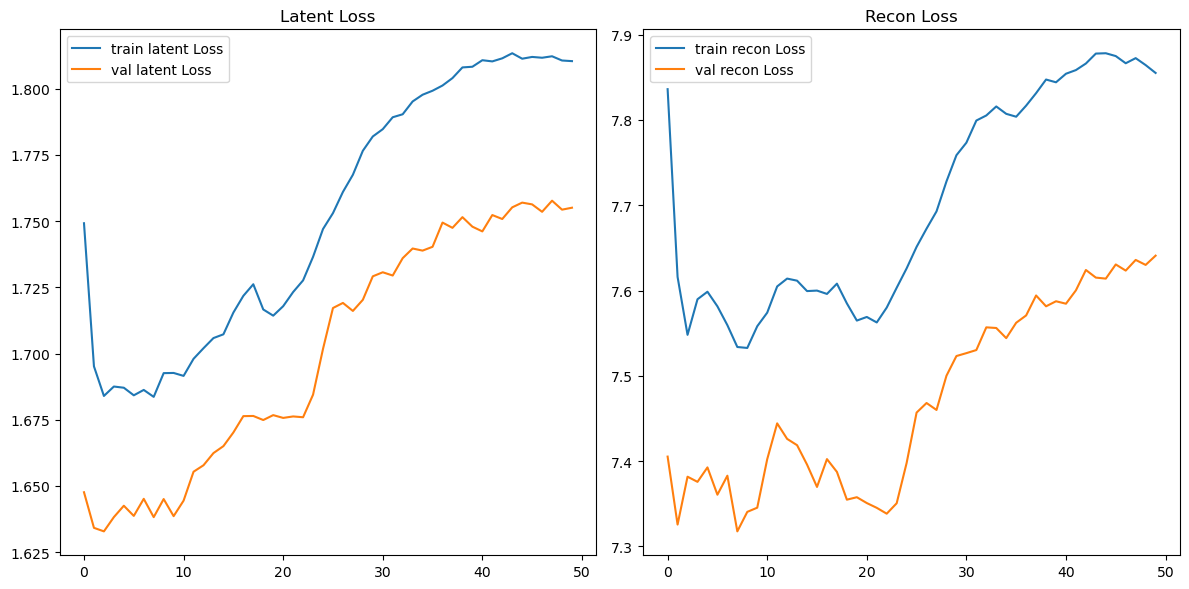

In [18]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_latent_loss_list, train_recon_loss_list, val_latent_loss_list, val_recon_loss_list 
axs[0].plot(train_latent_loss_list, label='train latent Loss')
axs[0].plot(val_latent_loss_list, label='val latent Loss')
axs[0].set_title("Latent Loss")
axs[0].legend()

axs[1].plot(train_recon_loss_list, label='train recon Loss')
axs[1].plot(val_recon_loss_list, label='val recon Loss')
axs[1].set_title("Recon Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
plt.show()

# Performance in test set

In [30]:
model = LSTM_Seq2seq(5, 5, 49, 10, 49)
# 加载保存的状态字典
state_dict = torch.load('/home/scheng1/wl4023/IRP/BaselineModels/LSTM/models/CAE_LSTM.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [31]:
x, y = seq_real_test_set[0]
print(x.shape, y.shape)

torch.Size([5, 1, 97149]) torch.Size([5, 1, 97149])


In [33]:
model.eval()
test_latent_loss_list = []
test_recon_loss_list = []
criterion = RMSELoss()

with torch.no_grad():
    latent_test_loss = 0
    recon_test_loss = 0
    for real_x, real_y in tqdm(seq_real_test_set):
        # 编码
        real_x, real_y = real_x.to(device), real_y.to(device) # (5, 1, 97149)
        latent_x = cae.encoder(real_x).unsqueeze(0) # 为latent_x增加batch size (1, 5, 49)
        latent_y = cae.encoder(real_y) # (5, 49)

        latent_predict = model(latent_x).squeeze() # (5, 49)


        latent_test_loss = criterion(latent_y, latent_predict).item()

        recon_predict = cae.decoder(latent_predict) # (5, 1, 97149)
        recon_test_loss = criterion(real_y, recon_predict).item()

        test_latent_loss_list.append(latent_test_loss)
        test_recon_loss_list.append(recon_test_loss)
    
    test_latent_loss_list = np.array(test_latent_loss_list)
    test_recon_loss_list = np.array(test_recon_loss_list)
    print(f'Ave test latent Loss: {test_latent_loss_list.mean()}, Ave test recon Loss: {test_recon_loss_list.mean()}')

100%|██████████| 19/19 [00:00<00:00, 28.27it/s]

Ave test latent Loss: 5.754421460001092, Ave test recon Loss: 31.526363372802734


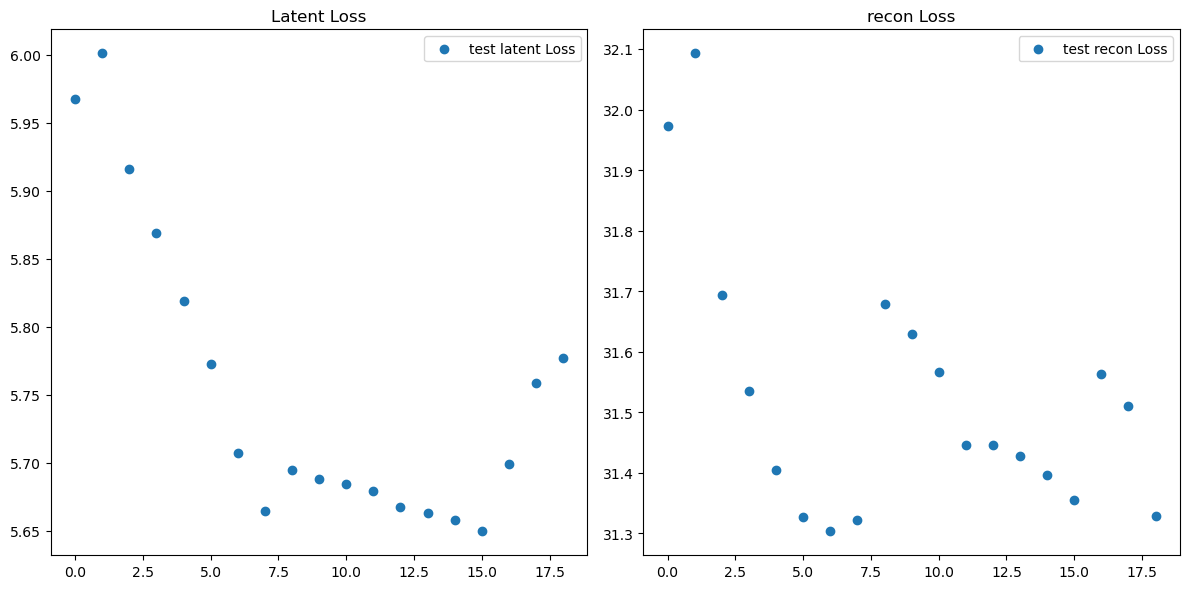

In [34]:
x = np.arange(0, len(seq_real_test_set))

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_latent_loss_list, label='test latent Loss')
axs[0].set_title("Latent Loss")
axs[0].legend()

axs[1].scatter(x, test_recon_loss_list, label='test recon Loss')
axs[1].set_title("recon Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.show()

In [36]:
real_x, real_y = seq_real_test_set[0]

real_x, real_y = real_x.to(device), real_y.to(device) # (5, 1, 97149)
latent_x = cae.encoder(real_x).unsqueeze(0) # 为latent_x增加batch size (1, 5, 49)
latent_y = cae.encoder(real_y) # (5, 49)

latent_predict = model(latent_x).squeeze() # (5, 49)

recon_predict = cae.decoder(latent_predict) # (5, 1, 97149)

In [37]:
def draw_pic(real_x, real_y, recon_y, coords):

    vmin = min(np.min(real_x), np.min(real_y), np.min(recon_y))
    vmax = max(np.max(real_x), np.max(real_y), np.max(recon_y))

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=real_x[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('real input')
    fig1.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=real_y[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('real output')
    fig2.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig3, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=recon_y[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('reconstructed output')
    fig3.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

In [38]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [39]:
real_x_np = real_x.detach().numpy().squeeze()
real_y_np = real_y.detach().numpy().squeeze()
recon_y_np = recon_predict.detach().numpy().squeeze()

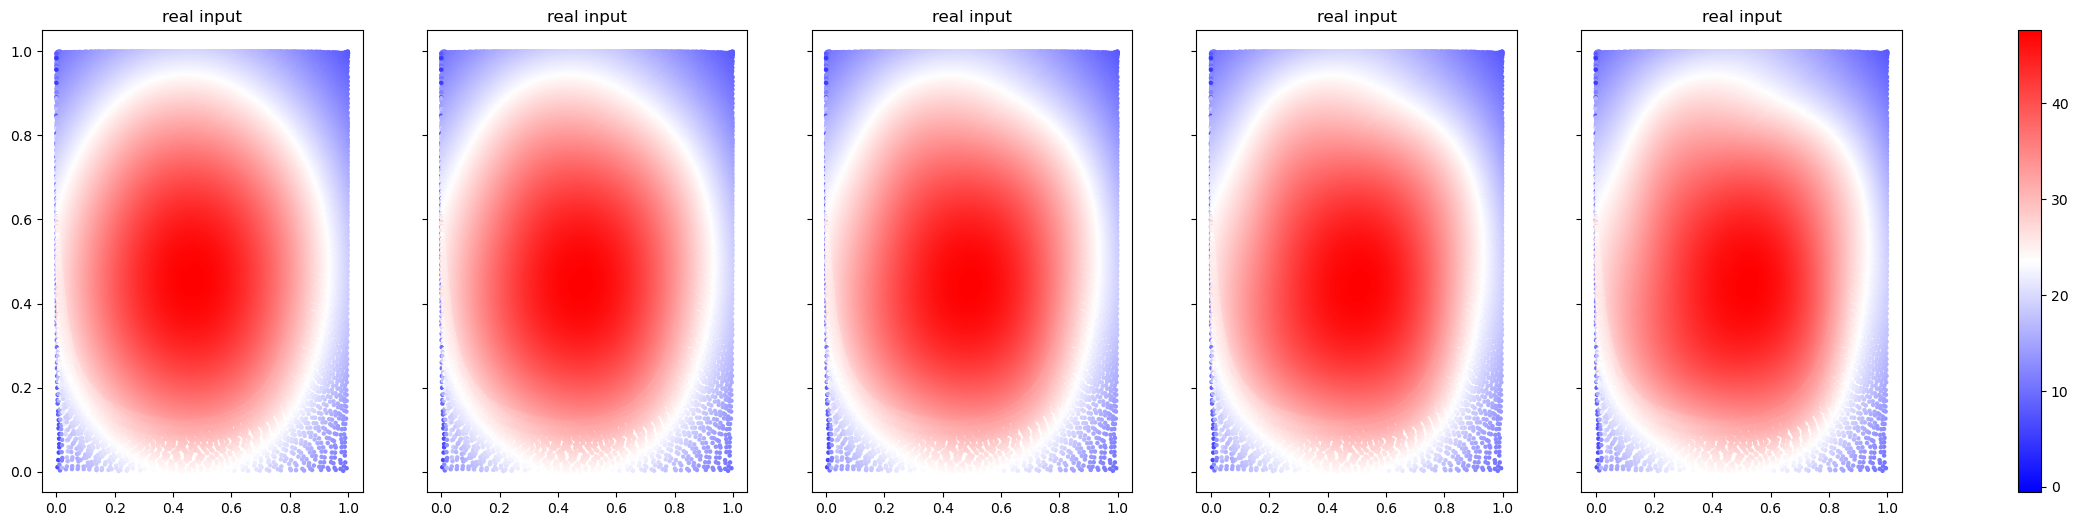

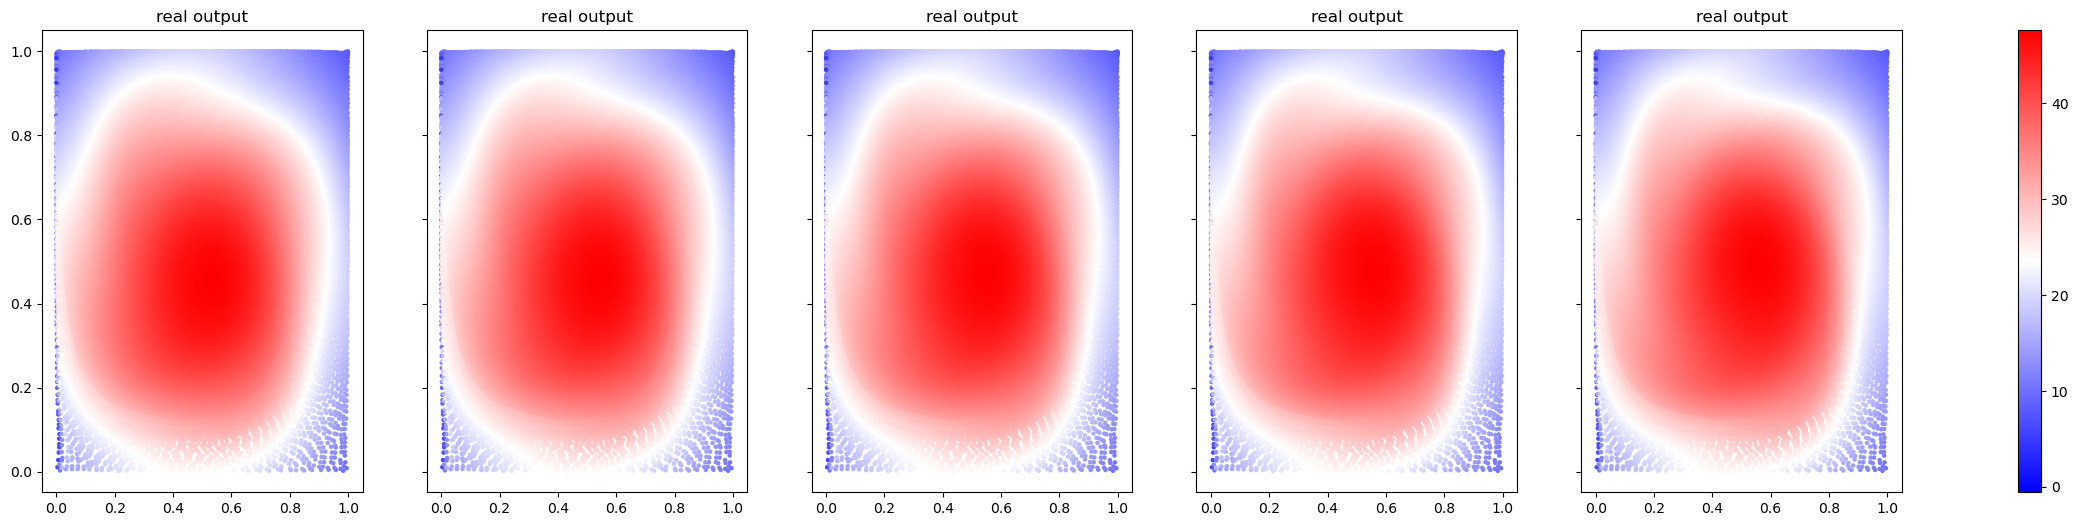

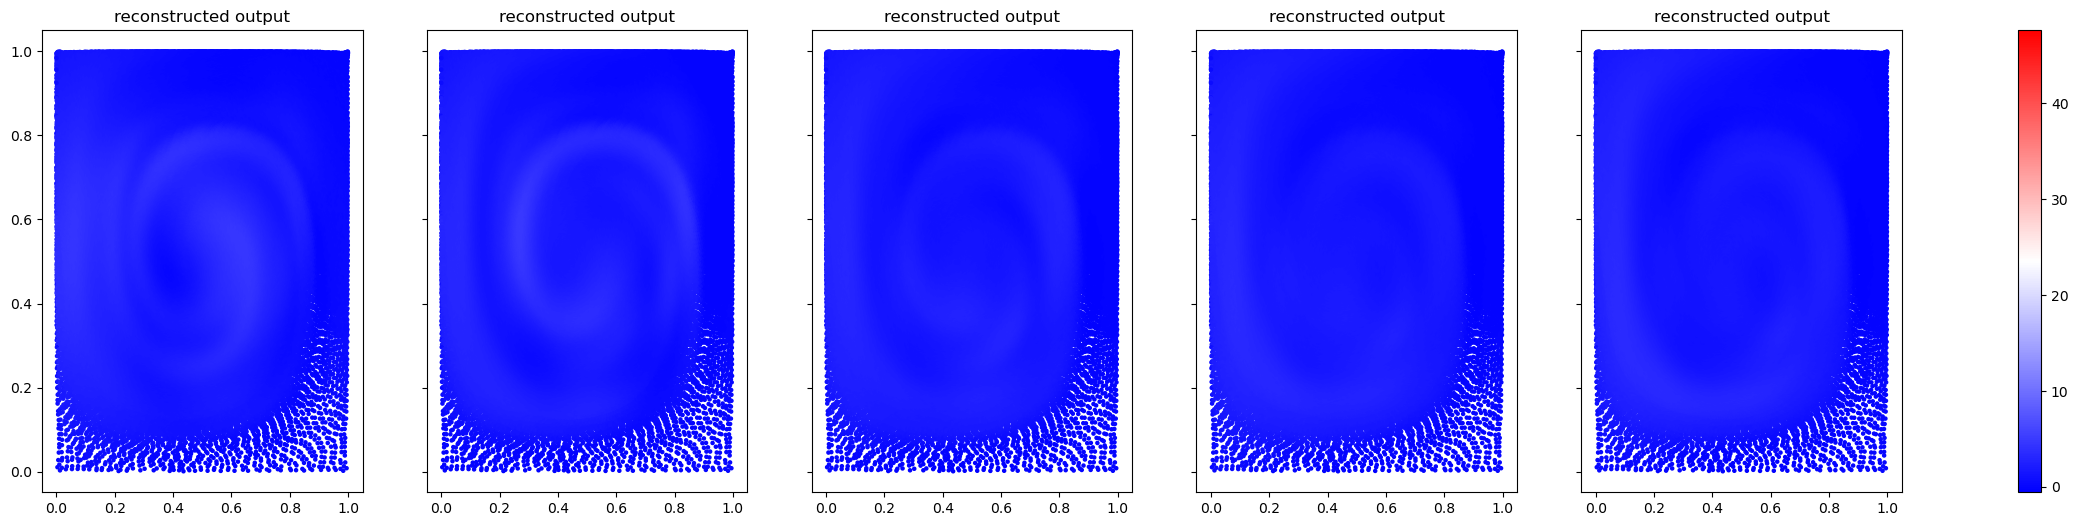

In [41]:
draw_pic(real_x_np, real_y_np, recon_y_np, pos)